In [1]:
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import torch
import random
import os

def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [3]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from collections import Counter

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [4]:
result = pd.read_csv('./Test_AD_results_Anode.csv')

In [5]:
anomaly_score = result['score']
ground_truth = result['true_label']

In [73]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = np.percentile(anomaly_score, 80), 
                                                                end = np.percentile(anomaly_score, 90), 
                                                                step_num = 1000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.6340, F1: 0.4335, Precision: 1.0000, Recall: 0.2767


In [74]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(378, 0, 703, 269)

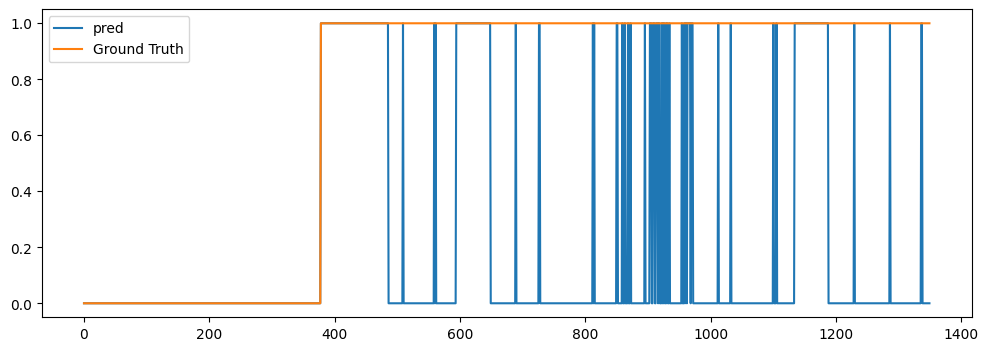

In [75]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

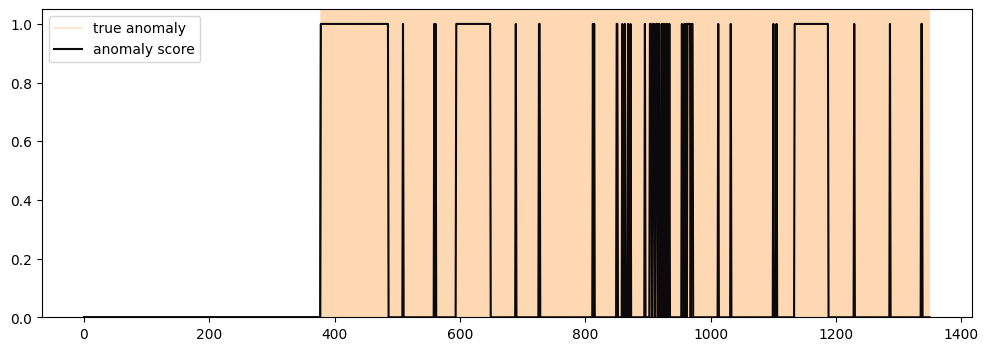

In [76]:
check_graph(pred, np.array(ground_truth))
plt.show()

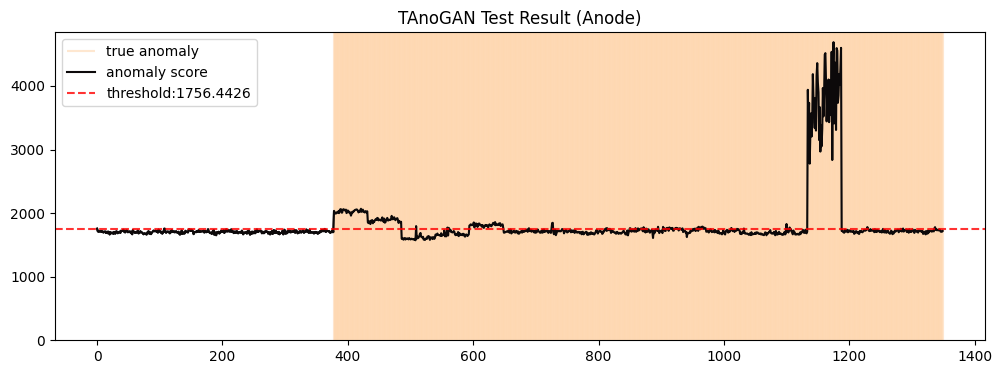

In [77]:
check_graph(anomaly_score, ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Anode)')
plt.show()

In [72]:
bead_counter = []
for i in range(len(pred)//54):
    bead_counter.append(dict(Counter(pred[i*54: (i+1)*54])))
print(bead_counter)

[{0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {1: 54}, {1: 54}, {0: 54}, {0: 54}, {0: 17, 1: 37}, {0: 54}, {0: 52, 1: 2}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 53, 1: 1}, {1: 54}, {0: 54}, {0: 54}, {0: 54}]


In [77]:
thres = []
f1_ = []
prec = []
recall_ = []
precision_thres = []
# Threshold Sensitivity

for th in np.linspace(float(min(result['score'])), float(max(result['score'])),10000):

    thres.append(th)
    f1_.append(f1)
    prec.append(precision)
    recall_.append(recall)

    f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], th, 100, False)

    if precision >= 0.9:
        precision_thres.append(th)

    print(f'F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}')
    
metrics = pd.DataFrame([thres, f1_, prec, recall_]).T
metrics.columns = ['threshold', 'f1', 'precision', 'recall']

F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8367, Prec: 0.7198, Recall: 0.9990
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8362, Prec: 0.7196, Recall: 0.9979
F1: 0.8357, Prec: 0.7194, Recall: 0.9969
F1: 0.8357, Prec: 0.7194, Recall: 0.9969
F1: 0.8357, Prec: 0.7194, Recall: 0.9969
F1: 0.8357, Prec

In [86]:
# Threshold when Precision > 0.9

pred = (anomaly_score>precision_thres[0]).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], precision_thres[0], 100, False)

print(f'AUROC: {auroc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.6340, F1: 0.6022, Precision: 0.9033, Recall: 0.4516


Text(0.5, 0.01, 'Threshold')

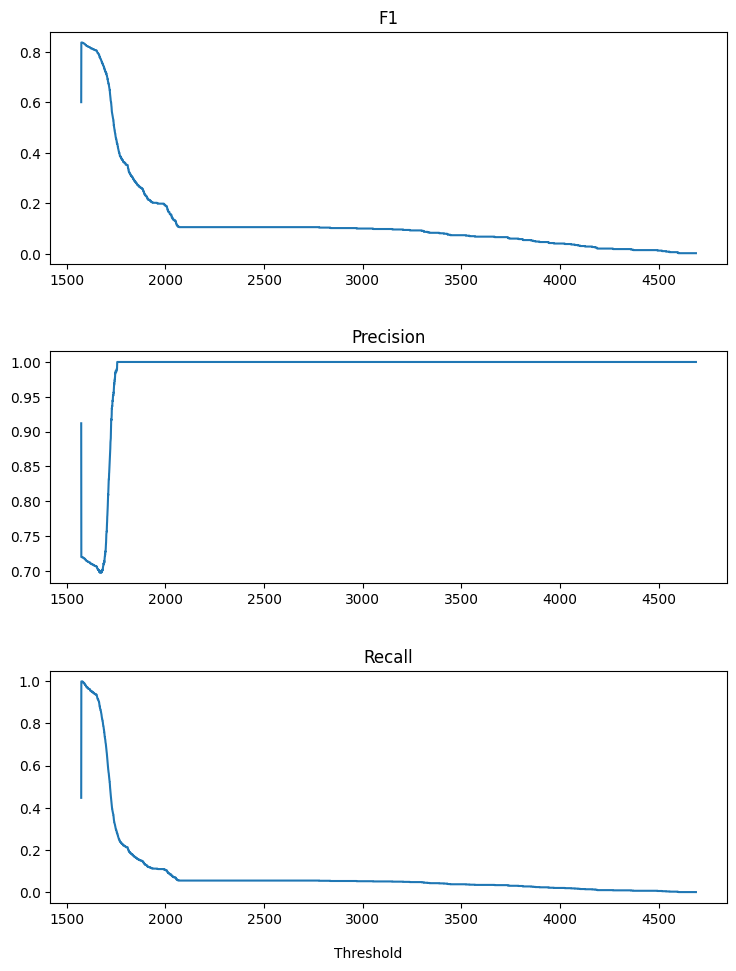

In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(metrics['threshold'])
y1 = np.array(metrics['f1'])
y2 = np.array(metrics['precision'])
y3 = np.array(metrics['recall'])

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot the data on each subplot
axs[0].plot(x, y1)
axs[0].set_title('F1')
axs[1].plot(x, y2)
axs[1].set_title('Precision')
axs[2].plot(x, y3)
axs[2].set_title('Recall')

# Add a common x-axis label and adjust the spacing between subplots
fig.tight_layout(pad=3.0)
fig.text(0.5, 0.01, 'Threshold', ha='center')

In [4]:
from extract_rule_based_features import ExtractFeatures, detect_bead

def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

In [5]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])

data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])

for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Test = pd.concat([Anode_Test, bead_i])

warning index: 40140
error index: 40239
warning index: 40690
error index: 40789
warning index: 41239
error index: 41338
warning index: 41788
error index: 41887
warning index: 42337
error index: 42436
warning index: 42886
error index: 42985
warning index: 43436
error index: 43535
warning index: 43986
error index: 44085
warning index: 44535
error index: 44634
warning index: 45085
error index: 45184
warning index: 45634
error index: 45733
warning index: 46184
error index: 46283
warning index: 46733
error index: 46832
warning index: 47282
error index: 47381
warning index: 47832
error index: 47931
warning index: 48381
error index: 48480
warning index: 48930
error index: 49029
warning index: 49479
error index: 49578
warning index: 50028
error index: 50127
warning index: 50577
error index: 50676
warning index: 51127
error index: 51226
warning index: 51676
error index: 51775
warning index: 52226
error index: 52325
warning index: 52775
error index: 52874
warning index: 53325
error index: 53424


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 50276
error index: 50375
warning index: 50826
error index: 50925
warning index: 51375
error index: 51474
warning index: 51924
error index: 52023
warning index: 52473
error index: 52572
warning index: 53022
error index: 53121
warning index: 53572
error index: 53671
warning index: 54122
error index: 54221
warning index: 54671
error index: 54770
warning index: 55221
error index: 55320
warning index: 55770
error index: 55869
warning index: 56320
error index: 56419
warning index: 56869
error index: 56968
warning index: 57418
error index: 57517
warning index: 57968
error index: 58067
warning index: 58517
error index: 58616
warning index: 59066
error index: 59165
warning index: 59615
error index: 59714
warning index: 60164
error index: 60263
warning index: 60713
error index: 60812
warning index: 61263
error index: 61362
warning index: 61812
error index: 61911
warning index: 62362
error index: 62461
warning index: 62911
error index: 63010
warning index: 63461
error index: 63560


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 41027
error index: 41126
warning index: 41577
error index: 41676
warning index: 42126
error index: 42225
warning index: 42675
error index: 42774
warning index: 43224
error index: 43323
warning index: 43773
error index: 43872
warning index: 44323
error index: 44422
warning index: 44873
error index: 44972
warning index: 45422
error index: 45521
warning index: 45972
error index: 46071
warning index: 46521
error index: 46620
warning index: 47071
error index: 47170
warning index: 47620
error index: 47719
warning index: 48169
error index: 48268
warning index: 48719
error index: 48818
warning index: 49268
error index: 49367
warning index: 49817
error index: 49916
warning index: 50366
error index: 50465
warning index: 50915
error index: 51014
warning index: 51466
error index: 51563
warning index: 52014
error index: 52113
warning index: 52563
error index: 52662
warning index: 53113
error index: 53212
warning index: 53662
error index: 53761
warning index: 54212
error index: 54311


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47108
warning index: 47109
error index: 47207
warning index: 47658
error index: 47757
warning index: 48207
warning index: 48208
error index: 48306
warning index: 48756
error index: 48855
warning index: 49305
warning index: 49306
error index: 49404
warning index: 49854
warning index: 49855
error index: 49953
warning index: 50404
warning index: 50405
error index: 50503
warning index: 50954
warning index: 50955
error index: 51053
warning index: 51503
error index: 51602
warning index: 52053
warning index: 52054
error index: 52152
warning index: 52602
warning index: 52603
error index: 52701
warning index: 53152
warning index: 53153
error index: 53251
warning index: 53701
error index: 53800
warning index: 54250
warning index: 54251
error index: 54349
warning index: 54800
error index: 54899
warning index: 55349
warning index: 55350
error index: 55448
warning index: 55898
warning index: 55899
error index: 55997
warning index: 56447
warning index: 56448
error index: 56546
warning

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 46925
warning index: 46926
error index: 47024
warning index: 47475
warning index: 47476
error index: 47574
warning index: 48024
error index: 48123
warning index: 48573
error index: 48672
warning index: 49122
error index: 49221
warning index: 49671
error index: 49770
warning index: 50221
error index: 50320
warning index: 50771
error index: 50870
warning index: 51320
warning index: 51321
error index: 51419
warning index: 51870
warning index: 51871
error index: 51969
warning index: 52419
error index: 52518
warning index: 52969
error index: 53068
warning index: 53518
error index: 53617
warning index: 54067
warning index: 54068
error index: 54166
warning index: 54617
warning index: 54618
error index: 54716
warning index: 55166
error index: 55265
warning index: 55715
error index: 55814
warning index: 56264
error index: 56363
warning index: 56812
error index: 56912
warning index: 57362
error index: 57461
warning index: 57912
error index: 58011
warning index: 58461
error index: 

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44185
error index: 44284
warning index: 44735
error index: 44834
warning index: 45284
error index: 45383
warning index: 45833
error index: 45932
warning index: 46382
error index: 46481
warning index: 46931
error index: 47030
warning index: 47481
error index: 47580
warning index: 48031
error index: 48130
warning index: 48580
error index: 48679
warning index: 49130
error index: 49229
warning index: 49679
error index: 49778
warning index: 50229
error index: 50328
warning index: 50778
error index: 50877
warning index: 51327
error index: 51426
warning index: 51877
error index: 51976
warning index: 52426
error index: 52525
warning index: 52975
error index: 53074
warning index: 53524
error index: 53623
warning index: 54073
error index: 54172
warning index: 54622
error index: 54721
warning index: 55172
error index: 55271
warning index: 55721
error index: 55820
warning index: 56271
error index: 56370
warning index: 56820
error index: 56919
warning index: 57370
error index: 57469


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 50916
error index: 51014
warning index: 51466
error index: 51564
warning index: 52015
error index: 52113
warning index: 52564
error index: 52662
warning index: 53113
error index: 53211
warning index: 53661
warning index: 53662
error index: 53760
warning index: 54212
error index: 54310
warning index: 54762
error index: 54860
warning index: 55311
error index: 55409
warning index: 55860
warning index: 55861
error index: 55959
warning index: 56409
warning index: 56410
error index: 56508
warning index: 56959
warning index: 56960
error index: 57058
warning index: 57508
warning index: 57509
error index: 57607
warning index: 58057
warning index: 58058
error index: 58156
warning index: 58608
error index: 58706
warning index: 59156
warning index: 59157
error index: 59255
warning index: 59706
error index: 59804
warning index: 60254
warning index: 60255
error index: 60353
warning index: 60804
error index: 60902
warning index: 61353
error index: 61451
warning index: 61903
error index

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 46607
error index: 46706
warning index: 47157
error index: 47256
warning index: 47706
error index: 47804
warning index: 48255
error index: 48353
warning index: 48804
error index: 48902
warning index: 49353
error index: 49451
warning index: 49903
error index: 50001
warning index: 50453
error index: 50551
error index: 50552
warning index: 51002
error index: 51100
warning index: 51552
error index: 51650
error index: 51651
warning index: 52101
error index: 52199
warning index: 52651
error index: 52749
warning index: 53200
error index: 53298
warning index: 53749
error index: 53847
error index: 53848
warning index: 54299
error index: 54397
warning index: 54848
error index: 54946
warning index: 55397
error index: 55495
warning index: 55946
error index: 56044
warning index: 56495
error index: 56593
warning index: 57044
error index: 57142
warning index: 57594
error index: 57692
warning index: 58143
error index: 58241
warning index: 58693
error index: 58791
error index: 58792
warn

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44186
error index: 44285
warning index: 44736
error index: 44835
warning index: 45285
error index: 45384
warning index: 45834
error index: 45933
warning index: 46383
error index: 46482
warning index: 46932
error index: 47031
warning index: 47482
error index: 47581
warning index: 48032
error index: 48131
warning index: 48581
error index: 48680
warning index: 49131
error index: 49230
warning index: 49680
error index: 49779
warning index: 50230
error index: 50329
warning index: 50779
error index: 50878
warning index: 51328
error index: 51427
warning index: 51878
error index: 51977
warning index: 52427
error index: 52526
warning index: 52976
error index: 53075
warning index: 53525
error index: 53624
warning index: 54074
error index: 54173
warning index: 54623
error index: 54722
warning index: 55173
error index: 55272
warning index: 55722
error index: 55821
warning index: 56272
error index: 56371
warning index: 56821
error index: 56920
warning index: 57371
error index: 57470


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 49734
error index: 49832
warning index: 50284
error index: 50382
warning index: 50833
error index: 50931
warning index: 51382
error index: 51480
warning index: 51931
error index: 52029
warning index: 52480
error index: 52578
warning index: 53030
error index: 53128
warning index: 53580
error index: 53678
warning index: 54129
error index: 54227
warning index: 54679
error index: 54777
warning index: 55228
error index: 55326
warning index: 55778
error index: 55876
warning index: 56327
error index: 56425
warning index: 56876
error index: 56974
warning index: 57426
error index: 57524
warning index: 57975
error index: 58073
warning index: 58524
error index: 58622
warning index: 59073
error index: 59171
warning index: 59622
error index: 59720
warning index: 60171
error index: 60269
warning index: 60721
error index: 60819
warning index: 61270
error index: 61368
warning index: 61819
error index: 61918
warning index: 62368
error index: 62467
warning index: 62918
error index: 63017


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40641
error index: 40740
warning index: 41191
error index: 41290
warning index: 41740
error index: 41839
warning index: 42289
error index: 42388
warning index: 42838
error index: 42937
warning index: 43387
error index: 43486
warning index: 43937
error index: 44036
warning index: 44487
error index: 44586
warning index: 45036
error index: 45135
warning index: 45586
error index: 45685
warning index: 46135
error index: 46234
warning index: 46685
error index: 46784
warning index: 47234
error index: 47333
warning index: 47783
error index: 47882
warning index: 48333
warning index: 48882
error index: 48981
warning index: 49431
error index: 49530
warning index: 49980
error index: 50079
warning index: 50529
error index: 50628
warning index: 51078
error index: 51177
warning index: 51628
error index: 51727
warning index: 52177
error index: 52276
warning index: 52727
error index: 52826
warning index: 53276
error index: 53375
warning index: 53826
error index: 53925
warning index: 5437

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40906
error index: 41005
warning index: 41456
error index: 41555
warning index: 42005
error index: 42104
warning index: 42554
error index: 42653
warning index: 43103
error index: 43202
warning index: 43652
error index: 43751
warning index: 44202
error index: 44301
warning index: 44752
error index: 44851
warning index: 45301
error index: 45400
warning index: 45851
error index: 45950
warning index: 46400
error index: 46499
warning index: 46950
error index: 47049
warning index: 47499
error index: 47598
warning index: 48048
error index: 48147
warning index: 48598
error index: 48697
warning index: 49147
error index: 49246
warning index: 49696
error index: 49795
warning index: 50245
error index: 50344
warning index: 50794
error index: 50893
warning index: 51343
error index: 51442
warning index: 51893
error index: 51992
warning index: 52442
error index: 52541
warning index: 52992
error index: 53091
warning index: 53541
error index: 53640
warning index: 54091
error index: 54190


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45939
error index: 46037
warning index: 46489
warning index: 47038
error index: 47136
error index: 47137
warning index: 47587
error index: 47685
error index: 47686
warning index: 48136
error index: 48234
warning index: 48684
warning index: 48685
error index: 48783
error index: 49333
error index: 49883
warning index: 50333
warning index: 50334
error index: 50432
error index: 50433
warning index: 50884
error index: 50982
error index: 50983
warning index: 51432
warning index: 51433
error index: 51531
warning index: 51982
warning index: 51983
error index: 52081
error index: 52630
warning index: 53081
error index: 53179
warning index: 53631
error index: 53729
warning index: 54179
warning index: 54180
error index: 54278
warning index: 54729
error index: 54827
warning index: 55277
warning index: 55278
error index: 55376
warning index: 55826
warning index: 55827
error index: 55925
warning index: 56375
warning index: 56376
error index: 56474
error index: 56475
warning index: 5692

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45347
error index: 45446
warning index: 45897
error index: 45996
warning index: 46446
error index: 46545
warning index: 46995
error index: 47094
warning index: 47544
error index: 47643
warning index: 48093
error index: 48192
warning index: 48643
error index: 48742
warning index: 49193
error index: 49292
warning index: 49742
error index: 49841
warning index: 50292
error index: 50390
warning index: 50841
error index: 50939
warning index: 51391
error index: 51489
warning index: 51940
error index: 52038
warning index: 52489
error index: 52587
warning index: 53039
error index: 53137
warning index: 53588
error index: 53686
warning index: 54137
error index: 54235
warning index: 54686
error index: 54784
warning index: 55235
error index: 55333
warning index: 55784
error index: 55882
warning index: 56334
error index: 56432
warning index: 56883
error index: 56981
warning index: 57433
error index: 57531
warning index: 57982
error index: 58080
warning index: 58532
error index: 58630


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 71554
error index: 71652
warning index: 72103
warning index: 72104
error index: 72202
warning index: 72652
warning index: 72653
error index: 72751
warning index: 73201
warning index: 73202
error index: 73300
warning index: 73750
error index: 73849
warning index: 74299
warning index: 74300
error index: 74398
warning index: 74849
warning index: 74850
error index: 74948
warning index: 75399
error index: 75498
warning index: 75948
error index: 76047
warning index: 76498
warning index: 76499
error index: 76597
warning index: 77047
error index: 77146
warning index: 77597
error index: 77696
warning index: 78146
error index: 78245
warning index: 78695
warning index: 78696
error index: 78794
warning index: 79245
warning index: 79246
error index: 79344
warning index: 79794
error index: 79893
warning index: 80343
error index: 80442
warning index: 80892
warning index: 80893
error index: 80991
warning index: 81441
error index: 81540
warning index: 81990
error index: 82089
warning ind

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44914
error index: 45013
warning index: 45464
error index: 45563
warning index: 46013
error index: 46112
warning index: 46562
warning index: 47111
error index: 47210
warning index: 47660
error index: 47759
warning index: 48210
error index: 48309
warning index: 48760
error index: 48859
warning index: 49309
error index: 49408
warning index: 49859
error index: 49958
warning index: 50408
error index: 50507
warning index: 50958
error index: 51057
warning index: 51507
error index: 51606
warning index: 52056
error index: 52155
warning index: 52606
error index: 52705
warning index: 53155
error index: 53254
warning index: 53704
error index: 53803
warning index: 54253
error index: 54352
warning index: 54802
error index: 54901
warning index: 55351
error index: 55450
warning index: 55901
error index: 56000
warning index: 56450
error index: 56549
warning index: 57000
error index: 57099
warning index: 57549
error index: 57648
warning index: 58099
error index: 58198
warning index: 5864

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 37222
error index: 37320
warning index: 37771
warning index: 37772
error index: 37870
warning index: 38320
warning index: 38321
error index: 38419
warning index: 38869
warning index: 38870
error index: 38968
warning index: 39418
error index: 39517
warning index: 39967
warning index: 39968
error index: 40066
warning index: 40517
warning index: 40518
error index: 40616
warning index: 41067
warning index: 41068
error index: 41166
warning index: 41616
error index: 41715
warning index: 42166
warning index: 42167
error index: 42265
warning index: 42715
warning index: 42716
error index: 42814
warning index: 43265
warning index: 43266
error index: 43364
warning index: 43814
warning index: 43815
error index: 43913
warning index: 44363
warning index: 44364
error index: 44462
warning index: 44913
error index: 45012
warning index: 45462
warning index: 45463
error index: 45561
warning index: 46011
error index: 46110
warning index: 46560
warning index: 46561
error index: 46659
warning

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40508
error index: 40607
warning index: 41058
error index: 41157
warning index: 41607
error index: 41706
warning index: 42156
error index: 42255
warning index: 42705
error index: 42804
warning index: 43254
error index: 43353
warning index: 43804
error index: 43903
warning index: 44354
error index: 44453
warning index: 44903
error index: 45002
warning index: 45453
error index: 45552
warning index: 46002
error index: 46101
warning index: 46552
error index: 46651
warning index: 47101
error index: 47200
warning index: 47650
error index: 47749
warning index: 48200
error index: 48299
warning index: 48749
error index: 48848
warning index: 49298
error index: 49397
warning index: 49847
error index: 49946
warning index: 50396
error index: 50495
warning index: 50945
error index: 51044
warning index: 51495
error index: 51594
warning index: 52044
error index: 52143
warning index: 52594
error index: 52693
warning index: 53143
error index: 53242
warning index: 53693
error index: 53792


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45317
error index: 45416
warning index: 45867
error index: 45966
warning index: 46416
error index: 46515
warning index: 46965
error index: 47064
warning index: 47514
error index: 47613
warning index: 48063
error index: 48162
warning index: 48613
error index: 48712
warning index: 49163
error index: 49262
warning index: 49712
error index: 49811
warning index: 50262
error index: 50361
warning index: 50811
error index: 50910
warning index: 51361
error index: 51460
warning index: 51910
error index: 52009
warning index: 52459
error index: 52558
warning index: 53009
error index: 53108
warning index: 53558
error index: 53657
warning index: 54107
error index: 54206
warning index: 54656
error index: 54755
warning index: 55205
error index: 55304
warning index: 55754
error index: 55853
warning index: 56304
error index: 56403
warning index: 56853
error index: 56952
warning index: 57403
error index: 57502
warning index: 57952
error index: 58051
warning index: 58502
error index: 58601


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 55019
warning index: 55020
error index: 55118
warning index: 55569
error index: 55668
warning index: 56118
error index: 56217
warning index: 56667
error index: 56766
warning index: 57216
error index: 57315
warning index: 57765
error index: 57864
warning index: 58315
error index: 58414
warning index: 58865
error index: 58964
warning index: 59414
error index: 59513
warning index: 59964
error index: 60063
warning index: 60513
error index: 60612
warning index: 61063
error index: 61162
warning index: 61612
error index: 61711
warning index: 62161
error index: 62260
warning index: 62711
error index: 62810
warning index: 63260
error index: 63359
warning index: 63809
error index: 63908
warning index: 64358
error index: 64457
warning index: 64907
error index: 65005
warning index: 65456
error index: 65554
warning index: 66006
error index: 66104
warning index: 66555
error index: 66653
warning index: 67105
error index: 67203
warning index: 67654
error index: 67752
warning index: 6820

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 53078
error index: 53177
warning index: 53628
error index: 53727
warning index: 54177
error index: 54276
warning index: 54726
error index: 54825
warning index: 55275
error index: 55374
warning index: 55824
error index: 55923
warning index: 56374
error index: 56473
warning index: 56924
error index: 57023
warning index: 57473
error index: 57572
warning index: 58023
error index: 58122
warning index: 58572
error index: 58671
warning index: 59122
error index: 59221
warning index: 59671
error index: 59770
warning index: 60220
error index: 60319
warning index: 60770
error index: 60869
warning index: 61319
error index: 61418
warning index: 61868
error index: 61967
warning index: 62417
error index: 62516
warning index: 62966
error index: 63065
warning index: 63515
error index: 63614
warning index: 64065
error index: 64164
warning index: 64614
error index: 64713
warning index: 65164
error index: 65263
warning index: 65713
error index: 65812
warning index: 66263
error index: 66362


/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47096
error index: 47194
warning index: 47645
warning index: 47646
error index: 47744
warning index: 48194
warning index: 48195
error index: 48293
warning index: 48743
error index: 48842
warning index: 49292
warning index: 49293
error index: 49391
warning index: 49841
warning index: 49842
error index: 49940
warning index: 50391
warning index: 50392
error index: 50490
warning index: 50941
warning index: 50942
error index: 51040
warning index: 51490
error index: 51589
warning index: 52040
error index: 52139
warning index: 52589
error index: 52688
warning index: 53139
error index: 53238
warning index: 53688
error index: 53787
warning index: 54237
error index: 54336
warning index: 54787
error index: 54886
warning index: 55336
error index: 55435
warning index: 55885
error index: 55984
warning index: 56434
error index: 56533
warning index: 56983
error index: 57082
warning index: 57532
error index: 57631
warning index: 58082
error index: 58181
warning index: 58631
error index: 

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45366
error index: 45465
warning index: 45916
error index: 46015
warning index: 46465
error index: 46564
warning index: 47014
error index: 47113
warning index: 47563
error index: 47662
warning index: 48112
error index: 48211
warning index: 48662
error index: 48761
warning index: 49212
error index: 49311
warning index: 49761
error index: 49860
warning index: 50311
error index: 50409
error index: 50410
warning index: 50860
error index: 50958
warning index: 51410
error index: 51508
warning index: 51959
error index: 52057
warning index: 52508
error index: 52606
error index: 52607
warning index: 53058
error index: 53156
warning index: 53607
error index: 53705
warning index: 54156
error index: 54254
warning index: 54705
error index: 54803
error index: 54804
warning index: 55254
error index: 55352
error index: 55353
warning index: 55803
error index: 55901
warning index: 56353
error index: 56451
warning index: 56902
error index: 57000
warning index: 57452
error index: 57550
warn

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39624
error index: 39722
error index: 39723
warning index: 40174
error index: 40272
error index: 40273
warning index: 40723
error index: 40821
warning index: 41272
error index: 41370
warning index: 41821
error index: 41919
warning index: 42370
error index: 42468
warning index: 42920
error index: 43018
warning index: 43470
error index: 43568
warning index: 44019
error index: 44117
warning index: 44569
error index: 44667
warning index: 45118
error index: 45216
warning index: 45668
error index: 45766
warning index: 46217
error index: 46315
warning index: 46766
error index: 46864
warning index: 47316
error index: 47414
warning index: 47865
error index: 47963
warning index: 48414
error index: 48512
warning index: 48962
error index: 49061
warning index: 49511
error index: 49610
warning index: 50060
error index: 50159
warning index: 50610
error index: 50709
warning index: 51159
error index: 51258
warning index: 51709
error index: 51808
warning index: 52258
error index: 52357
wa

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44167
warning index: 44168
error index: 44266
warning index: 44717
warning index: 44718
error index: 44816
warning index: 45266
warning index: 45267
error index: 45365
warning index: 45815
warning index: 45816
error index: 45914
warning index: 46364
warning index: 46365
error index: 46463
warning index: 46913
warning index: 46914
error index: 47012
warning index: 47463
warning index: 47464
error index: 47562
warning index: 48013
error index: 48112
warning index: 48562
error index: 48661
warning index: 49112
error index: 49211
warning index: 49661
error index: 49760
warning index: 50211
warning index: 50212
error index: 50310
warning index: 50760
warning index: 50761
error index: 50859
warning index: 51309
error index: 51408
warning index: 51859
error index: 51958
warning index: 52408
error index: 52507
warning index: 52957
warning index: 52958
error index: 53056
warning index: 53506
error index: 53605
warning index: 54055
error index: 54154
warning index: 54604
error ind

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47362
error index: 47461
warning index: 47912
error index: 48011
warning index: 48461
error index: 48560
warning index: 49010
error index: 49109
warning index: 49559
error index: 49658
warning index: 50108
error index: 50207
warning index: 50658
error index: 50757
warning index: 51208
error index: 51307
warning index: 51757
error index: 51856
warning index: 52307
error index: 52406
warning index: 52856
error index: 52955
warning index: 53406
error index: 53505
warning index: 53955
error index: 54054
warning index: 54504
error index: 54603
warning index: 55054
error index: 55153
warning index: 55603
error index: 55702
warning index: 56152
error index: 56251
warning index: 56701
error index: 56800
warning index: 57250
error index: 57349
warning index: 57799
error index: 57898
warning index: 58349
error index: 58448
warning index: 58898
error index: 58997
warning index: 59447
warning index: 59448
error index: 59546
warning index: 59996
error index: 60095
warning index: 6054

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47049
error index: 47148
warning index: 47599
error index: 47698
warning index: 48148
error index: 48246
warning index: 48697
error index: 48795
warning index: 49245
warning index: 49246
error index: 49344
warning index: 49795
error index: 49893
warning index: 50345
error index: 50443
warning index: 50895
error index: 50993
warning index: 51444
error index: 51542
warning index: 51994
error index: 52092
warning index: 52542
warning index: 52543
error index: 52641
warning index: 53092
warning index: 53093
error index: 53191
warning index: 53641
warning index: 53642
error index: 53740
warning index: 54191
error index: 54289
warning index: 54741
error index: 54839
warning index: 55289
warning index: 55290
error index: 55388
warning index: 55839
error index: 55937
warning index: 56387
warning index: 56388
error index: 56486
warning index: 56936
warning index: 56937
error index: 57035
warning index: 57486
error index: 57584
warning index: 58036
error index: 58134
warning index

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 41600
error index: 41699
warning index: 42150
error index: 42249
warning index: 42699
error index: 42798
warning index: 43248
error index: 43347
warning index: 43797
error index: 43896
warning index: 44346
error index: 44445
warning index: 44896
error index: 44995
warning index: 45446
error index: 45545
warning index: 45995
error index: 46094
warning index: 46545
error index: 46644
warning index: 47094
error index: 47192
warning index: 47644
error index: 47742
warning index: 48193
error index: 48291
warning index: 48742
error index: 48840
error index: 48841
warning index: 49291
warning index: 49292
error index: 49390
error index: 49391
warning index: 49841
error index: 49939
warning index: 50390
error index: 50488
warning index: 50938
warning index: 50939
error index: 51037
error index: 51038
warning index: 51488
error index: 51586
error index: 51587
warning index: 52037
error index: 52135
warning index: 52587
error index: 52685
warning index: 53136
error index: 53234
wa

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47596
warning index: 47597
error index: 47695
warning index: 48146
error index: 48245
warning index: 48695
error index: 48794
warning index: 49244
error index: 49343
warning index: 49793
error index: 49892
warning index: 50342
error index: 50441
warning index: 50892
error index: 50991
warning index: 51442
error index: 51541
warning index: 51991
error index: 52090
warning index: 52541
error index: 52640
warning index: 53090
error index: 53189
warning index: 53640
error index: 53739
warning index: 54189
error index: 54288
warning index: 54738
error index: 54837
warning index: 55288
error index: 55387
warning index: 55837
error index: 55936
warning index: 56386
error index: 56485
warning index: 56935
error index: 57034
warning index: 57484
error index: 57583
warning index: 58033
error index: 58131
warning index: 58583
error index: 58681
warning index: 59132
error index: 59230
warning index: 59682
error index: 59780
warning index: 60231
error index: 60329
warning index: 6078

/tmp/ipykernel_422215/3395440298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_422215/3395440298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_422215/3395440298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 52382
error index: 52480
error index: 52481
warning index: 52932
error index: 53031
warning index: 53481
error index: 53579
warning index: 54030
error index: 54128
warning index: 54579
error index: 54677
warning index: 55128
error index: 55226
warning index: 55678
error index: 55776
warning index: 56228
error index: 56326
warning index: 56777
error index: 56875
warning index: 57327
error index: 57425
warning index: 57876
error index: 57974
warning index: 58426
error index: 58524
warning index: 58975
error index: 59073
warning index: 59524
error index: 59622
warning index: 60074
error index: 60172
warning index: 60623
error index: 60721
warning index: 61172
error index: 61270


In [22]:
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler

class create_dataset(Dataset):
    
    def __init__(
                self, train_data, test_data, 
                feature_names : list, 
                window_length: int = 100, step_size: int = 100, 
                mode:str = 'train'
                ):
        
        super(create_dataset, self).__init__()

        self.window_length = window_length
        self.step_size = step_size

        train_label = train_data['label'].values
        test_label = test_data['label'].values

        self.scaler = StandardScaler()

        train_data = self.scaler.fit_transform(train_data[feature_names])
        test_data = self.scaler.transform(test_data[feature_names].values)

        self.data = train_data if mode == 'train' else test_data
        self.label = train_label if mode == 'train' else test_label

        self.data = np.float32(self.data)
        self.label = np.float32(self.label)
        
    def __len__(self):
        
        return (self.data.shape[0] - self.window_length) // self.step_size + 1
    
    def __getitem__(self, idx):
        
        idx = idx * self.step_size

        xx = self.data[idx:idx+self.window_length]
        yy = self.label[idx:idx+self.window_length]
                
        return xx, yy

In [23]:
import torch.nn as nn
import torch

class Dis(nn.Module):
    def __init__(self, in_dim, hidden_size):
        super(Dis, self).__init__()

        self.in_dim = in_dim
        self.hidden_size = hidden_size

        self.layer1 = nn.LSTM(in_dim, hidden_size=hidden_size, num_layers = 1, batch_first = True)
        self.linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())

    def forward(self, x, h_0, c_0):

        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        output = out.reshape(batch_size * window_size, self.hidden_size)

        output = self.linear(output).reshape(batch_size, window_size, 1)

        return output, out

In [24]:
class Gen(nn.Module):

    def __init__(self, in_dim, window_size):

        super(Gen,self).__init__()

        self.in_dim = in_dim
        self.window_size = window_size
        self.layer1 = nn.LSTM(in_dim, hidden_size = 32, num_layers = 1, batch_first = True) #stack of 3 LSTM with different hidden size
        self.layer2 = nn.LSTM(32, hidden_size = 64, num_layers = 1, batch_first = True)
        self.layer3 = nn.LSTM(64, hidden_size = 128, num_layers = 1, batch_first = True)
        self.FC = nn.Sequential(nn.Linear(128, in_dim), nn.Tanh())

    def forward(self, x, h_0, c_0):
        
        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        out, _ = self.layer2(out)
        out, _ = self.layer3(out)

        FC_input = out.reshape(batch_size * window_size, 128)

        output = self.FC(FC_input)

        output = output.reshape(batch_size, window_size, self.in_dim)

        return output, out

In [25]:
feature_names = ['LO','BR',	'NIR','VIS']

train_dataset = create_dataset(Anode_Train, Anode_Test, feature_names,
                          100,100,'train')

test_dataset = create_dataset(Anode_Train, Anode_Test, feature_names,
                          100,100,'test')

train_loader = DataLoader(train_dataset, 32, shuffle = True)

test_loader = DataLoader(test_dataset, 1, shuffle = False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch_seed(77)

gen_model = Gen(in_dim=4, window_size = 100)
gen_model.to(device)
dis_model = Dis(in_dim=4, hidden_size = 100)
dis_model.to(device)

criterion = torch.nn.BCELoss()
optimizer_g = torch.optim.Adam(params=gen_model.parameters(), lr = 1e-3)
optimizer_d = torch.optim.Adam(params=dis_model.parameters(), lr = 1e-3)

In [29]:
len(Anode_Test)/100

1350.0

In [ ]:
import torch
import torch.nn as nn
import logging
import wandb
import time
import pdb
import torch.nn.init as init
from torch.autograd import Variable
from collections import OrderedDict
import os
import json

_logger = logging.getLogger('train')

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(gen, dis, train_loader, 
    optimizer_G, optimizer_D, criterion, device,
    log_interval
    ):

    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    acc_d_real_m = AverageMeter()
    acc_d_fake_m = AverageMeter()
    acc_g_m = AverageMeter()

    losses_d_real_m = AverageMeter()
    losses_d_fake_m = AverageMeter()
    losses_g_m = AverageMeter()
    losses_d_m = AverageMeter()

    end = time.time()

    dis.train()
    gen.train()

    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

    for idx, (xx, _) in enumerate(train_loader):

        # Train Discriminator
        
        batch_size, window_size, in_dim = xx.size(0), xx.size(1), xx.size(2)

        optimizer_D.zero_grad()

        label = torch.ones((batch_size, window_size, 1)).to(device)
        label_size = label.flatten().shape[0]

        xx = xx.to(device)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        output,_ = dis(xx, h_0, c_0)
        
        loss_D_real = criterion(output, label)
        loss_D_real.backward()

        losses_d_real_m.update(loss_D_real.item())

        optimizer_D.step()

        preds = torch.round(output).detach().cpu()

        acc_d_real_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)

        output, _ = dis(fake.detach(), h_0, c_0)

        label = torch.zeros((batch_size, window_size, 1)).to(device)
        
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()

        losses_d_fake_m.update(loss_d_fake.item())
        loss_dis = loss_d_fake + loss_D_real
        optimizer_D.step()

        losses_d_m.update(loss_dis.item())

        preds = torch.round(output).detach().cpu()

        acc_d_fake_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        # Train Generator
        optimizer_G.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)
        
        label = torch.ones((batch_size, window_size, 1)).to(device)
        output, _ = dis(fake, h_0, c_0)

        loss_g = criterion(output, label)
        loss_g.backward()

        losses_g_m.update(loss_g.item())

        optimizer_G.step()

        preds = torch.round(output).detach().cpu()
        acc_g_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        if idx % log_interval == 0 and idx != 0:

            _logger.info('TRAIN Iteration: [{:>4d}/{}] \n'
                        'Loss D Real: {losses_d_real.val:>6.4f} ({losses_d_real.avg:>6.4f}) '
                        'Acc D Real: {acc_d_real.avg:.3%} \n'
                        'Loss D Fake: {losses_d_fake.val:>6.4f} ({losses_d_fake.avg:>6.4f}) '
                        'Acc D Fake: {acc_d_fake.avg:.3%} \n'
                        'Loss D: {loss_dis:.3f} \n'
                        'Loss G: {losses_g.val:>6.4f} ({losses_g.avg:>6.4f}) '
                        'Acc G: {acc_g.avg:.3%} \n'
                        'LR: {lr:.3e} \n'.format(
                        idx+1, len(train_loader), 
                        losses_d_real = losses_d_real_m,
                        acc_d_real = acc_d_real_m,
                        losses_d_fake = losses_d_fake_m,
                        acc_d_fake = acc_d_fake_m,
                        loss_dis = loss_dis.item(),
                        losses_g = losses_g_m,
                        acc_g = acc_g_m,
                        lr    = optimizer_D.param_groups[0]['lr'],
                        )
            )

        end = time.time()

    return OrderedDict([('acc_d_real',acc_d_real_m.avg), ('loss_d_real',losses_d_real_m.avg),
                        ('acc_d_fake',acc_d_fake_m.avg), ('loss_d_real',losses_d_fake_m.avg),
                        ('acc_g',acc_g_m.avg), ('loss_g',losses_g_m.avg), ('loss_d', losses_d_m.avg)
                        ])

In [ ]:
from tqdm import tqdm
epochs = 20

for epoch in tqdm(range(epochs)):

    train_metrics = train(
                        gen = gen_model, dis = dis_model, train_loader = train_loader, optimizer_G = optimizer_g,
                        optimizer_D = optimizer_d, criterion = criterion, device = device, log_interval = 1
                        )
    
    print(train_metrics)

    metrics = OrderedDict(lr=optimizer_d.param_groups[0]['lr'])
    metrics.update([('train_' + k, v) for k, v in train_metrics.items()])

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_8692/2047780735.py:86: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
/tmp/ipykernel_8692/2047780735.py:108: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
  5%|▌         | 1/20 [00:00<00:08,  2.35it/s]

OrderedDict([('acc_d_real', 0.9218716931216931), ('loss_d_real', 0.6850056312978268), ('acc_d_fake', 0.4260383597883598), ('acc_g', 0.5691005291005291), ('loss_g', 0.7856218169132868), ('loss_d', 0.9205864748607079)])


 10%|█         | 2/20 [00:00<00:07,  2.54it/s]

OrderedDict([('acc_d_real', 0.9801455026455026), ('loss_d_real', 1.7688490397607286), ('acc_d_fake', 0.2275), ('acc_g', 0.6467526455026456), ('loss_g', 0.7756595704704523), ('loss_d', 1.904364123319586)])


 15%|█▌        | 3/20 [00:01<00:06,  2.59it/s]

OrderedDict([('acc_d_real', 0.9995701058201059), ('loss_d_real', 0.28590683980534476), ('acc_d_fake', 0.9966137566137566), ('acc_g', 0.002771164021164021), ('loss_g', 1.553470799078544), ('loss_d', 0.3129491067181031)])


 20%|██        | 4/20 [00:01<00:06,  2.63it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.14623056662579378), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 2.2608148604631424), ('loss_d', 0.15822431134680906)])


 25%|██▌       | 5/20 [00:01<00:05,  2.64it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.11073837367196877), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 2.5776583229502044), ('loss_d', 0.11798608116805553)])


 30%|███       | 6/20 [00:02<00:05,  2.65it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.06869402465720971), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 3.21130500237147), ('loss_d', 0.07441816649710138)])


 35%|███▌      | 7/20 [00:02<00:04,  2.66it/s]

OrderedDict([('acc_d_real', 0.9995502645502645), ('loss_d_real', 0.04840793530456722), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 3.6899304191271463), ('loss_d', 0.05360805608021716)])


 40%|████      | 8/20 [00:03<00:04,  2.66it/s]

OrderedDict([('acc_d_real', 0.9995502645502645), ('loss_d_real', 0.040513069330093764), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 4.007682591676712), ('loss_d', 0.04517084965482354)])


 45%|████▌     | 9/20 [00:03<00:04,  2.66it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.02437678596470505), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 4.4884999096393585), ('loss_d', 0.028706188313663006)])


 50%|█████     | 10/20 [00:03<00:03,  2.67it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.02040504877610753), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 4.802417357762654), ('loss_d', 0.02444022404961288)])


 55%|█████▌    | 11/20 [00:04<00:03,  2.67it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.017900302579316), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.090263605117798), ('loss_d', 0.021813113048362236)])


 60%|██████    | 12/20 [00:04<00:02,  2.68it/s]

OrderedDict([('acc_d_real', 0.9995568783068783), ('loss_d_real', 0.016163000313099474), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.344457983970642), ('loss_d', 0.019963390931176644)])


 65%|██████▌   | 13/20 [00:04<00:02,  2.68it/s]

OrderedDict([('acc_d_real', 0.999563492063492), ('loss_d_real', 0.015110140918598821), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.527486085891724), ('loss_d', 0.018689527913617592)])


 70%|███████   | 14/20 [00:05<00:02,  2.67it/s]

OrderedDict([('acc_d_real', 0.999563492063492), ('loss_d_real', 0.014189253386575729), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.735284606615703), ('loss_d', 0.017667472634154063)])


 75%|███████▌  | 15/20 [00:05<00:01,  2.68it/s]

OrderedDict([('acc_d_real', 0.9995701058201059), ('loss_d_real', 0.013770299051733067), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.885140011707942), ('loss_d', 0.017066646619544674)])


 80%|████████  | 16/20 [00:06<00:01,  2.68it/s]

OrderedDict([('acc_d_real', 0.9995767195767196), ('loss_d_real', 0.016101787080212187), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.71558063228925), ('loss_d', 0.01929852042424803)])


 85%|████████▌ | 17/20 [00:06<00:01,  2.69it/s]

OrderedDict([('acc_d_real', 0.9996097883597883), ('loss_d_real', 0.018396417028270662), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.310365209976832), ('loss_d', 0.021357558900490403)])


 90%|█████████ | 18/20 [00:06<00:00,  2.71it/s]

OrderedDict([('acc_d_real', 0.9996362433862434), ('loss_d_real', 0.014816807679987202), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.9206187923749285), ('loss_d', 0.01729000691557303)])


 95%|█████████▌| 19/20 [00:07<00:00,  2.71it/s]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.01241241106375431), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.13568635781606), ('loss_d', 0.013216701588438204)])


100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.011344770377036184), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.34149847428004), ('loss_d', 0.012086980219464749)])


In [ ]:
dis_loss_cand = train_metrics['loss_d']
gen_loss_cand = train_metrics['loss_g']

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.init as init
import pandas as pd
import os
import logging
import pdb

_logger = logging.getLogger('Optimization')

def Anomaly_score(latent, fake, latent_interm, fake_interm, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(latent-fake)) # Residual Loss
    
    discrimination_loss = torch.sum(torch.abs(latent_interm-fake_interm)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

def optimize(save_dir, dis, gen, test_loader, window_size, 
             in_dim, Lambda, iterations, device, log_interval):

    anomaly_score = []
    y_label = []
    #actual_obs = []
    test_anomaly_score = pd.DataFrame()

    dis.eval()
    gen.eval()

    torch.backends.cudnn.enabled = False
    
    for idx, (xx,yy) in enumerate(tqdm(test_loader)):

        y_label.append(yy[0][0].detach().item())
        #actual_obs.append(xx.flatten()[window_size-1].detach().item())

        xx = xx.to(device)
        batch_size = xx.size(0)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        z = Variable(init.normal(torch.zeros(batch_size, window_size, in_dim, device=device),mean = 0, std = 0.1),
                    requires_grad = True)

        z_optimizer =  torch.optim.Adam([z],lr = 0.01)
        
        _logger.info(f'\n Batch: {idx+1}/{len(test_loader)}')

        for iter in range(iterations):

            fake, _ = gen(z, h_g_0, c_g_0)
            _, x_feature = dis(xx, h_0, c_0) 
            _, G_z_feature = dis(fake, h_0, c_0) 

            loss = Anomaly_score(xx, fake, x_feature, G_z_feature, Lambda = Lambda)
            z_optimizer.zero_grad()
            loss.backward()
            z_optimizer.step()

        _logger.info('Batch [{}/{}]: Anomaly Score: {:.3f} label: {}'.format(idx+1, len(test_loader), loss.item(),yy[0][0].detach().item()))
                                                                                        
        anomaly_score.append(loss.item())

    #test_anomaly_score['actual_obs'] = actual_obs
    test_anomaly_score['score'] = anomaly_score
    test_anomaly_score['true_label'] = y_label

    test_anomaly_score.to_csv(save_dir,index=False)

In [ ]:
save_dir = '/workspace/Project_LG_Welding_AD/src'
df_dir = os.path.join(save_dir,'Test_AD_results.csv')

optimize(
        save_dir=df_dir,
        dis=dis_model,gen = gen_model, 
        test_loader = test_loader,
        window_size= 100,
        in_dim = 4,
        Lambda = 0.1,
        iterations = 50,
        device = device, 
        log_interval = int(50/5),
        )

  0%|          | 0/1350 [00:00<?, ?it/s]/tmp/ipykernel_8692/4210213411.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(batch_size, window_size, in_dim, device=device),mean = 0, std = 0.1),
100%|██████████| 1350/1350 [1:21:00<00:00,  3.60s/it]
